In [1]:
%load_ext autoreload
%autoreload 2


import json
import os
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import random
from math import floor

from ScheduleDistributionSampler import ScheduleDistributionSampler, activity_map, start_times, individual_histograms , KLdivergence, both_over_either


In [2]:
kl_mat = {}
sampler = {}
for per in ['hard_worker','home_maker','senior','work_from_home']:
    sampler[per] = ScheduleDistributionSampler(per)
for per in ['hard_worker','home_maker','senior','work_from_home']:
    kl_mat[per] = {}
    for per2 in ['hard_worker','home_maker','senior','work_from_home']:
        kl_mat[per][per2] = KLdivergence(sampler[per].activity_histogram, sampler[per2].activity_histogram)

kl_mat

{'hard_worker': {'hard_worker': 0.0,
  'home_maker': 4.16877271487728,
  'senior': 4.5568315354186355,
  'work_from_home': 6.423318700505599},
 'home_maker': {'hard_worker': 7.647769076320583,
  'home_maker': 0.0,
  'senior': 5.1472305620893355,
  'work_from_home': 4.6181191596920526},
 'senior': {'hard_worker': 7.154000308582614,
  'home_maker': 3.9208557395221844,
  'senior': 0.0,
  'work_from_home': 2.575020337219605},
 'work_from_home': {'hard_worker': 8.057587985569807,
  'home_maker': 3.8025161475087743,
  'senior': 3.207116973082938,
  'work_from_home': 0.0}}

In [3]:
print({a : {} for a in set(activity_map.values())})

{'listening_to_music': {}, 'cleaning': {}, 'vaccuum_cleaning': {}, 'leave_home': {}, 'dinner': {}, 'lunch': {}, 'taking_medication': {}, 'wash_dishes': {}, 'watching_tv': {}, 'brushing_teeth': {}, 'going_to_the_bathroom': {}, 'breakfast': {}, 'showering': {}, 'playing_music': {}, 'come_home': {}, 'take_out_trash': {}, None: {}, 'socializing': {}, 'getting_dressed': {}, 'computer_work': {}, 'reading': {}, 'laundry': {}, 'kitchen_cleaning': {}}


In [4]:
see_activities = list(set(activity_map.values()))
see_activities.remove(None)
# individual_histograms = {}

# schedule_num = 0
# for root, dirs, files in os.walk('data/AMT_Schedules'):
#     total_files = len(files) - 4
#     fig, ind_plot = plt.subplots(total_files, len(see_activities), sharex=True, sharey=True)
#     fig.set_size_inches(80, 50)
#     scene_histogram = {}
#     for f in files:
#         if f.endswith('.json'):
#             if f in ['A3EF9IKIU8IAHY.json', 'A3FKOG3VU5MP0X.json','AFER49XXMM4PE.json','A332L3FO6RCY6G.json']:
#                 continue
#             individual_histograms[f[:-5]] = {}
#             with open(os.path.join(root,f)) as file:
#                 sch = json.load(file)
#             age = int(sch["questionnaireData"]["age"][:2])
#             if sch["questionnaireData"]["gender"] == 'Female': c = [age/60, 0, 0]
#             if sch["questionnaireData"]["gender"] == 'Male': c = [0, 0, age/60]
#             # ind_plot[schedule_num,0].set_ylabel(str(age) + ', '+gender[0])
#             activity_times = {}
#             scene_histogram[f] = {k:{s:0 for s in start_times} for k in activity_map.values()}
#             for timestring,activities in sch['activitiesChosen'].items():
#                 start_time = timestring.split('m')[0]
#                 start_time = int(start_time[:-1]) if start_time[-1] == 'a' else int(start_time[:-1])+12
#                 if start_time == 24:
#                     start_time = 12
#                 for act in activities:
#                     sch_activity = activity_map[act]
#                     scene_histogram[f][sch_activity][start_time] = 1
#             for iact,act in enumerate(see_activities):
#                 individual_histograms[f[:-5]][act] = list(scene_histogram[f][act].values())
#                 ind_plot[schedule_num][iact].bar(scene_histogram[f][act].keys(), scene_histogram[f][act].values())
#                 ind_plot[schedule_num][iact].set_yticks([])
#                 ind_plot[schedule_num][iact].set_xticks([])
#             ind_plot[schedule_num,0].set_ylabel(f[:-5], rotation=0, labelpad=100)
#             schedule_num += 1
#     print('Done')
# schedule_num -= 1
# for iact, act in enumerate(see_activities):
#     ind_plot[0,iact].set_title(act.replace('_','\n'))
#     ind_plot[schedule_num][iact].set_xticks([6,9,12,15,18,21,24])
#     ind_plot[schedule_num][iact].set_xticklabels(['6\nam','','','3\npm','','','12\nam'])

In [5]:
# with open('data/personaBasedSchedules/individual_histograms.json', 'w') as f:
#     json.dump(individual_histograms, f, indent=4)

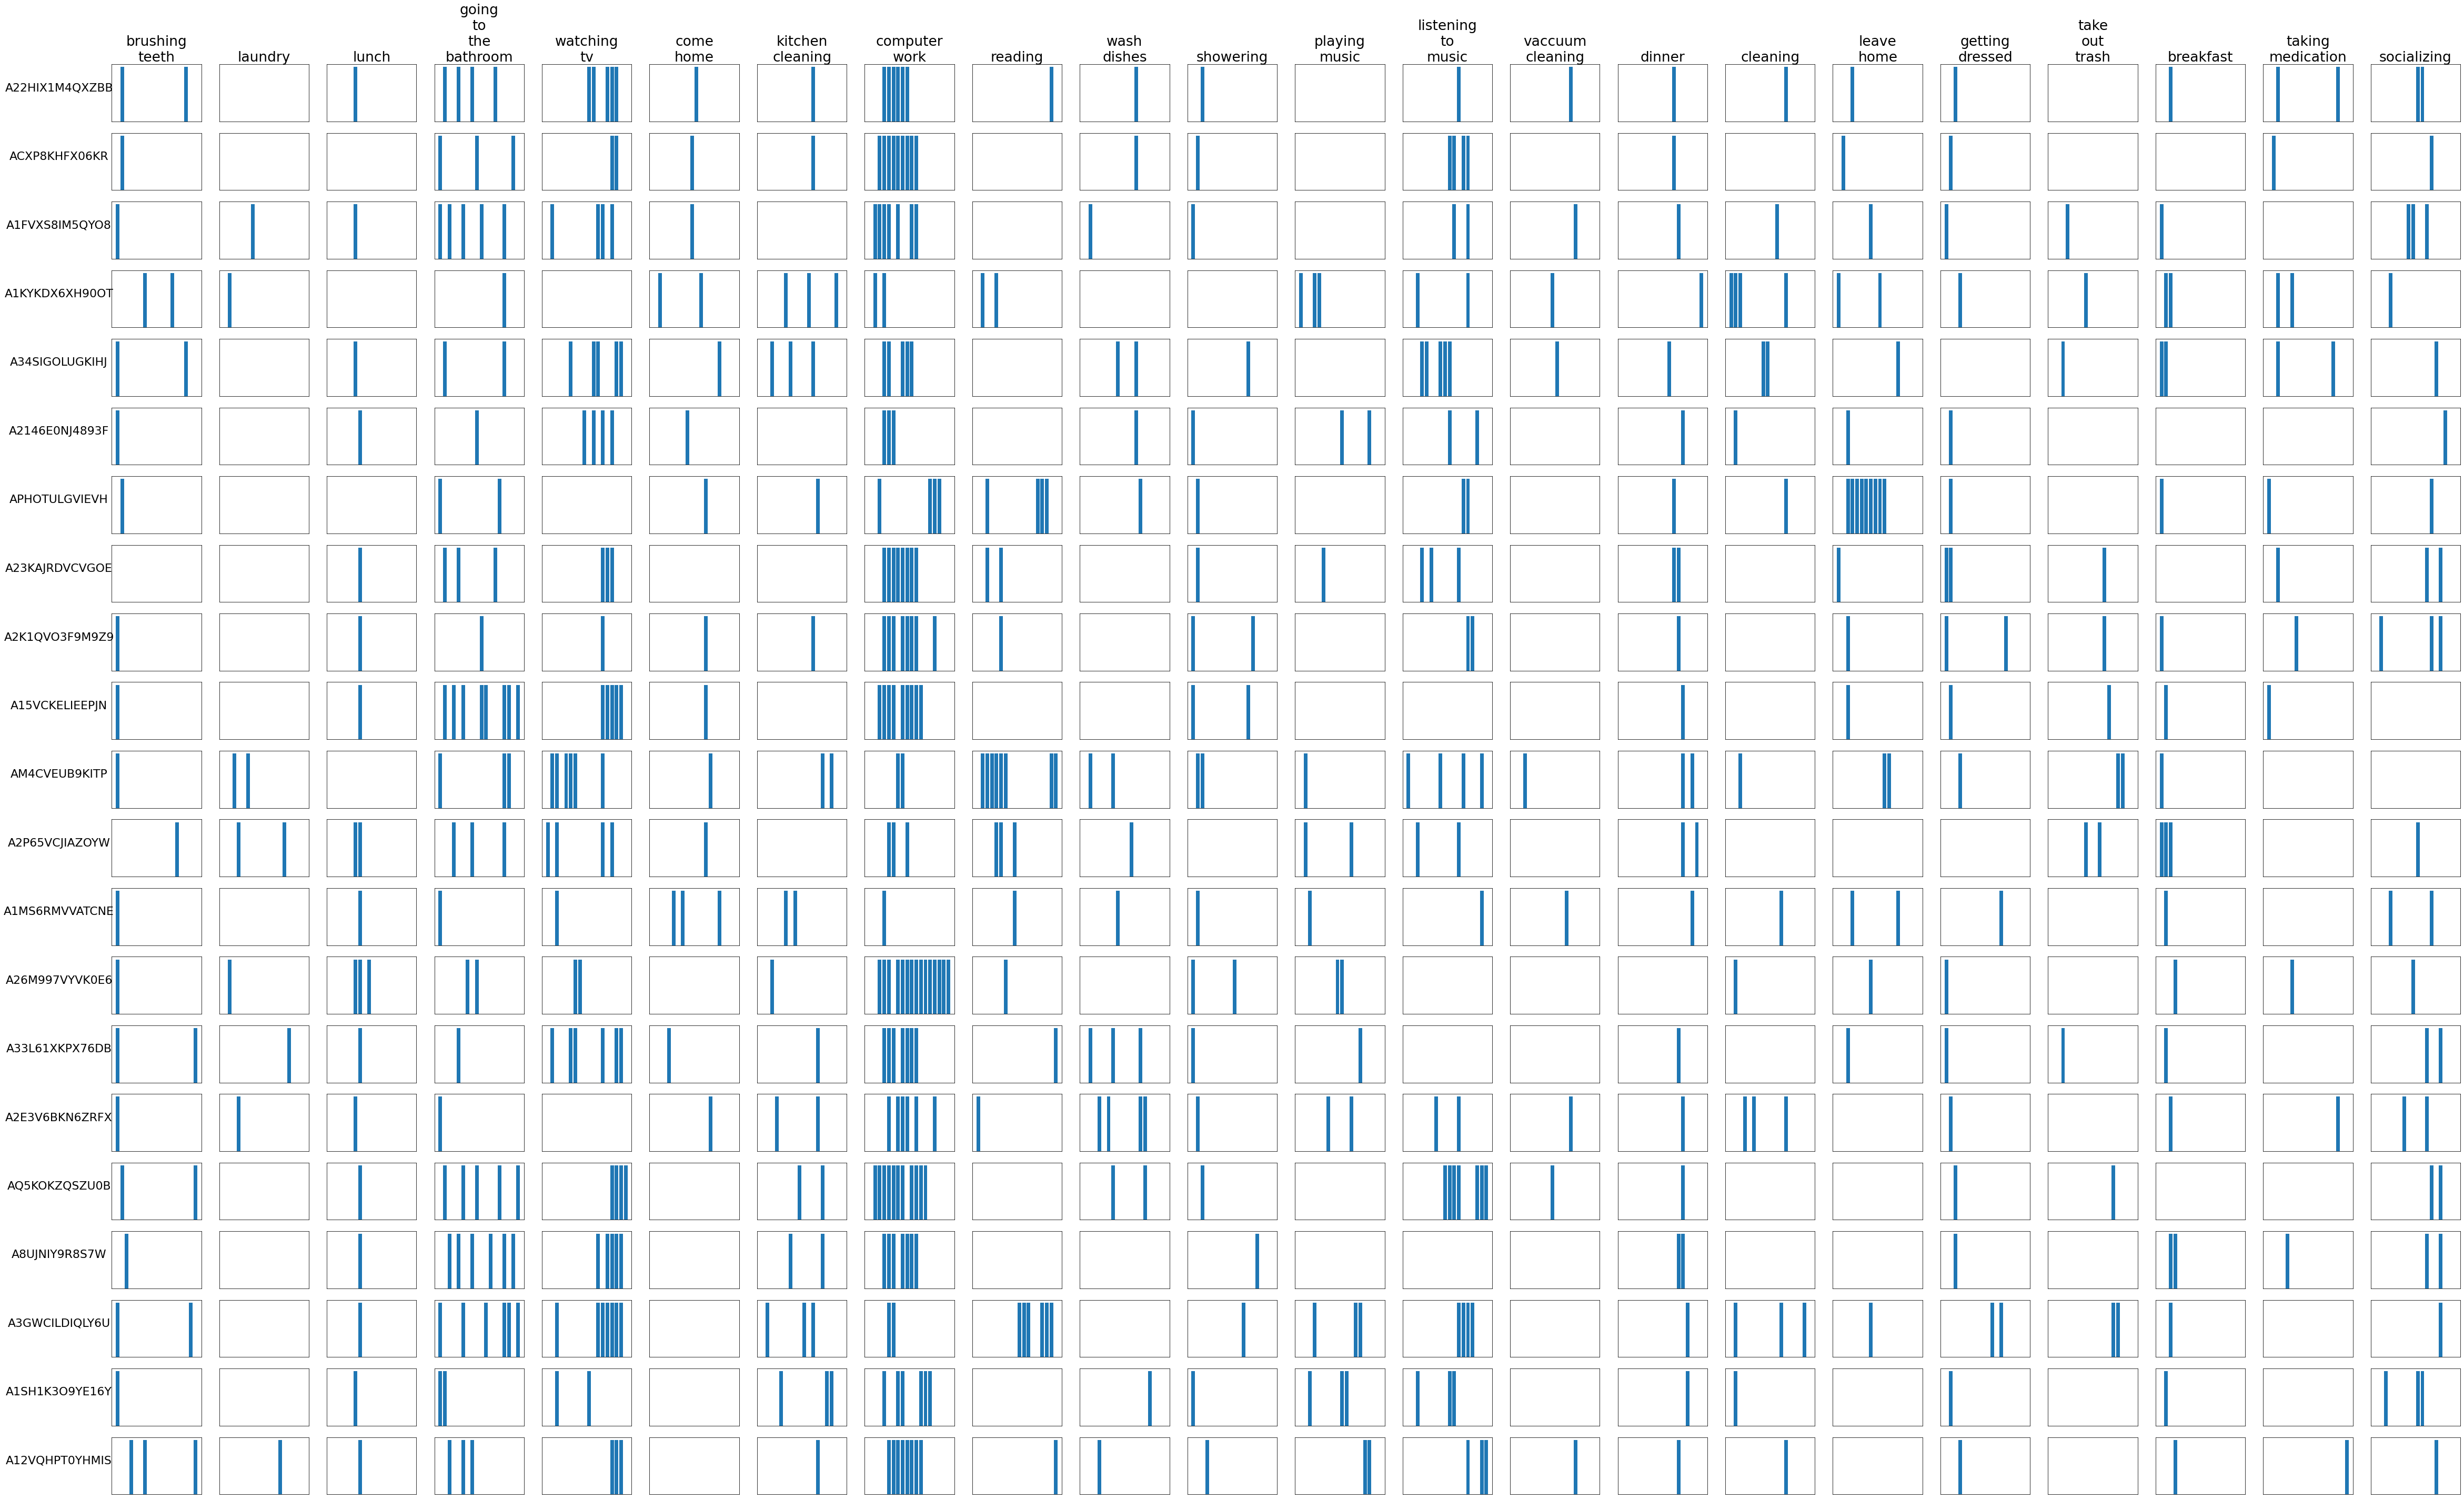

In [6]:
with open('data/personaBasedSchedules/corrected_histograms.json') as f:
    corrected_histograms = json.load(f)

fig, ind_plot = plt.subplots(len(corrected_histograms.keys()), len(see_activities), sharex=True, sharey=True)
fig.set_size_inches(80, 50)

for i,(id,act_hists) in enumerate(corrected_histograms.items()):
    for j,(activity,data) in enumerate(act_hists.items()):
        ind_plot[i][j].bar(start_times, data)
        ind_plot[i][j].set_yticks([])
        ind_plot[i][j].set_xticks([])
        if i==0:
            ind_plot[i][j].set_title(activity.replace('_','\n'))
    ind_plot[i][0].set_ylabel(id, rotation=0, labelpad=100)

### Rule-based habits

In [92]:
# persona_traits = {
# 'breakfast': {"has":[], "skips":[]}, 
# 'lunch': {"has":[], "skips":[]}, 
# 'dinner': {"has":[], "skips":[]}, 
# 'computer_work': {"less":[], "usual":[], "more":[]}, 
# 'going_to_the_bathroom': {"uses_bathroom":[], "does_not_use_bathroom":[]}, 
# 'leave_home': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'come_home': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'playing_music': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'getting_dressed': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'cleaning': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'socializing': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'listening_to_music':  {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'taking_medication': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'take_out_trash': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'kitchen_cleaning': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'wash_dishes': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'brushing_teeth': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'laundry': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'reading': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'showering': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'vaccuum_cleaning': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# 'watching_tv': {"morning":[], "evening":[], "multiple_times":[], "not_at_all":[]}, 
# }

In [93]:
# cutoff = 10
# computer_work_cutoffs = [4, 8]

# for i,(id,act_hists) in enumerate(corrected_histograms.items()):
#     for j,(activity,data) in enumerate(act_hists.items()):
#         np_data = np.array(data)
#         if set(list(persona_traits[activity].keys())) == set(["morning", "evening", "multiple_times", "not_at_all"]):
#             morning = np_data[:cutoff].sum() > 0
#             evening = np_data[cutoff:].sum() > 0
#             if morning and evening: persona_traits[activity]["multiple_times"].append(id)
#             elif morning: persona_traits[activity]["morning"].append(id)
#             elif evening: persona_traits[activity]["evening"].append(id)
#             else: persona_traits[activity]["not_at_all"].append(id)
#         if set(list(persona_traits[activity].keys())) == set(["has", "skips"]):
#             if (np_data.sum() > 0): persona_traits[activity]["has"].append(id)
#             else: persona_traits[activity]["skips"].append(id)
#         if activity == "computer_work":
#             if (np_data.sum() <= computer_work_cutoffs[0]): persona_traits[activity]["less"].append(id)
#             elif (np_data.sum() <= computer_work_cutoffs[1]): persona_traits[activity]["usual"].append(id)
#             else: persona_traits[activity]["more"].append(id)
#         if activity == "going_to_the_bathroom":
#             if (np_data.sum() > 0): persona_traits[activity]["uses_bathroom"].append(id)
#             else: persona_traits[activity]["does_not_use_bathroom"].append(id)

# persona_traits

In [94]:
# with open('data/personaBasedSchedules/persona_traits.json', 'w') as f:
#     json.dump(persona_traits, f, indent=4)

# persona_trait_frequencies = {act:{trait: len(files) for trait, files in trait_files.items()} for act,trait_files in persona_traits.items()}
# persona_trait_frequencies

In [95]:
# with open('data/personaBasedSchedules/persona_traits.json') as f:
#     persona_traits = json.load(f)

def plot_together(list_of_freqs, ax):
    for i,freqs in enumerate(list_of_freqs):
        freq_exist = np.array(start_times)[np.array(freqs) == 1]
        ax.plot(freq_exist,freq_exist*0 + i, '.')
        if sum(freqs) == 0:
            ax.plot(np.array(start_times),np.array(start_times)*0 + i, linewidth = 0.3, color=[0.8,0.8,0.8])


# trait_histograms = {}
# trait_probabilities = {}
# total_files = len(os.listdir('data/AMT_Schedules')) - 4

# for activity in persona_traits:
#     trait_histograms[activity] = {}
#     trait_probabilities[activity] = {}
#     fig, axs = plt.subplots(2, len(persona_traits[activity]), sharex=True)
#     fig.set_size_inches(20, 5)
#     fig.suptitle(activity)
#     for i, (trait, files) in enumerate(persona_traits[activity].items()):
#         if len(files) == 0:
#             continue
#         trait_histograms[activity][trait] = list((np.array([np.array(corrected_histograms[f][activity]) for f in files])).mean(0))
#         trait_probabilities[activity][trait] = len(files)/total_files
#         axs[1][i].plot(start_times, trait_histograms[activity][trait], '-.k')
#         axs[1][i].set_ylim([0,1])
#         plot_together([corrected_histograms[f][activity] for f in files], axs[0][i])
#         axs[0][i].set_title('{}; {}'.format(trait, len(files)))
#     fig.tight_layout()
#     plt.savefig('data/personaBasedSchedules/histograms/'+activity+'.jpg')


# with open('data/personaBasedSchedules/trait_histograms.json','w') as f:
#     json.dump(trait_histograms, f, indent=4)

In [96]:
# from copy import deepcopy
# samples = {1:[]}
# for activity, activity_traits in trait_probabilities.items():
#     prev_samples = deepcopy(samples)
#     samples = {}
#     for trait, prob in activity_traits.items():
#         for sample_prob, trait_list in prev_samples.items():
#             if sample_prob*prob > 0.00000000001:
#                 samples[sample_prob*prob] = trait_list + [(activity, trait)]
        

In [97]:
# from matplotlib import pyplot as plt
# probs = sorted(list(samples.keys()))[::-1]
# plt.plot(probs)
# # plt.xlim([0,20000])

### Clustering individuals

In [57]:
from ScheduleDistributionSampler import ScheduleDistributionSampler, activity_map, start_times, KLdivergence, individual_histograms
individual_histograms = corrected_histograms

In [58]:
activities = persona_traits.keys()
activities

dict_keys(['breakfast', 'lunch', 'dinner', 'computer_work', 'going_to_the_bathroom', 'leave_home', 'come_home', 'playing_music', 'getting_dressed', 'cleaning', 'socializing', 'listening_to_music', 'taking_medication', 'take_out_trash', 'kitchen_cleaning', 'wash_dishes', 'brushing_teeth', 'laundry', 'reading', 'showering', 'vaccuum_cleaning', 'watching_tv'])

In [82]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

individual_features = {}
activities = persona_traits.keys()

morning = np.array([1 if i<12 else 0 for i in range(6,24)])
afternoon = np.array([1 if i>=12 and i<18 else 0 for i in range(6,24)])
evening = np.array([1 if i>=18 else 0 for i in range(6,24)])

for act in activities:
    individual_features[act] = {}
    for indiv, act_hist in individual_histograms.items():
        feat = []
        seq = np.argwhere(act_hist[act]).reshape(-1)
        if len(seq) > 1:
            gm = GaussianMixture(n_components=2).fit(seq.reshape(-1,1))
            gm_means = gm.means_.reshape(-1)
            gm_covs = gm.covariances_.reshape(-1)
            gm_inds = gm_means.argsort()[::-1]
            gm_means = deepcopy(gm_means[gm_inds]).reshape(-1)
            gm_mean_diff = gm_means[0] - gm_means[1]
            gm_covs = deepcopy(gm_covs[gm_inds]).reshape(-1)
            median_time = np.median(seq)
        elif len(seq) == 1:
            gm_means = np.ones((2,)) * -1
            gm_means[0] = deepcopy(seq[0])
            gm_means[1] = deepcopy(seq[0])
            gm_mean_diff = 0
            gm_covs = np.zeros_like(gm_means)
            median_time = np.median(seq) if len(seq) > 0 else -1
        else:
            gm_means = np.ones((2,)) * -24
            gm_covs = np.ones((2,)) * -24
            gm_mean_diff = -24
            median_time = -24
        this_act = np.array(act_hist[act])
        feat += [sum(morning*this_act), sum(afternoon*this_act), sum(evening*this_act)]
        feat += list(gm_means)
        # feat += [gm_means[0]/18]
        # feat += [gm_mean_diff]
        # feat += list(gm_covs)
        # feat += [float(sum(act_hist[act]))]
        individual_features[act][indiv] = np.array(feat)

/tmp/ipykernel_2593768/2914727040.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(2, len(cluster_histograms[activity]), sharex=True)


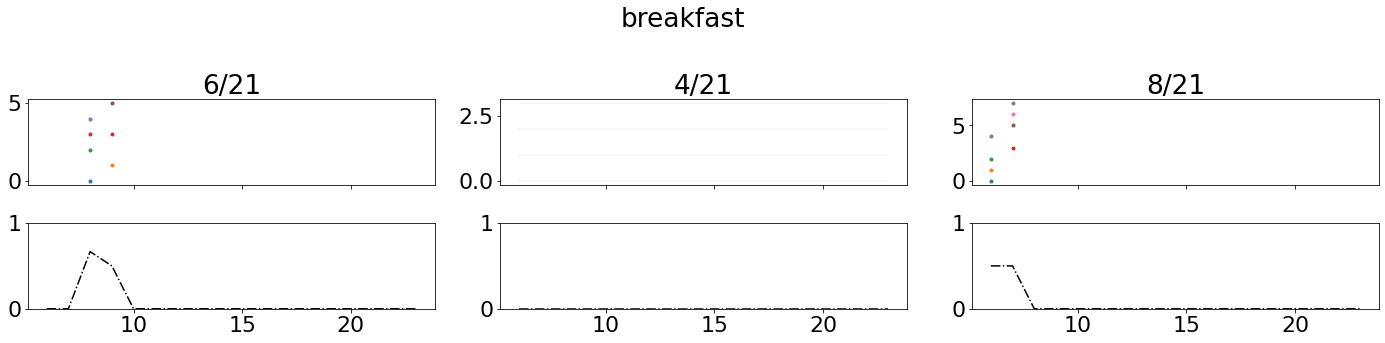

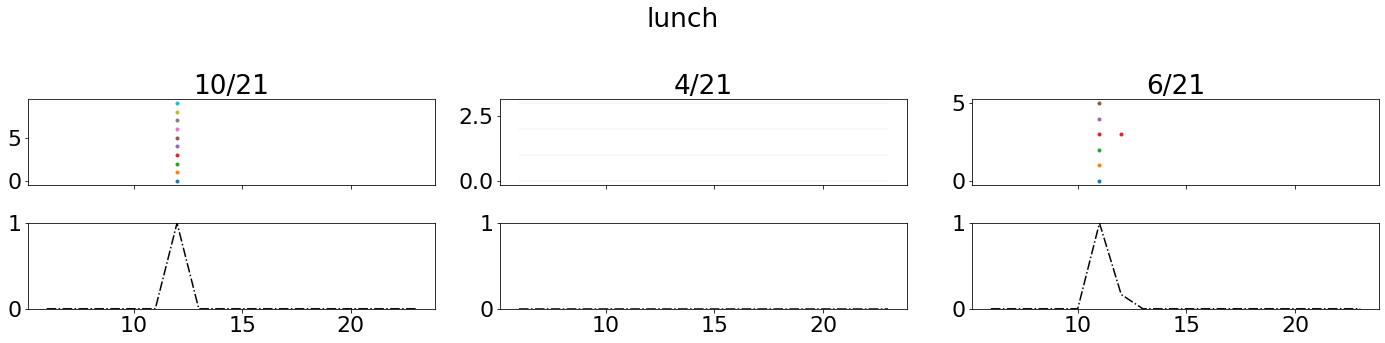

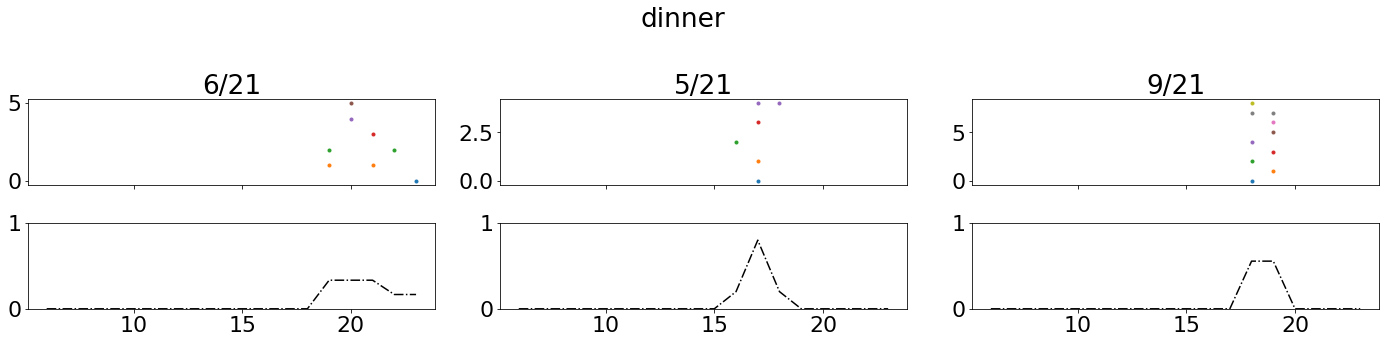

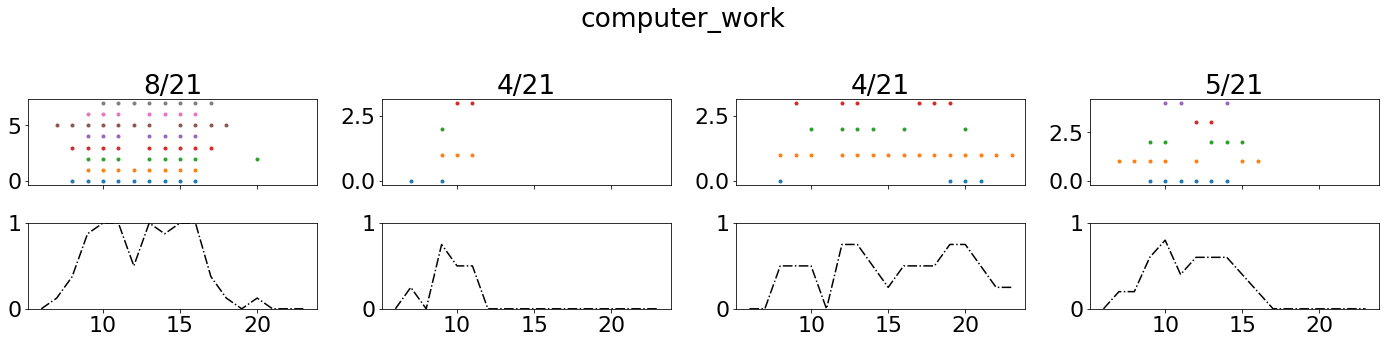

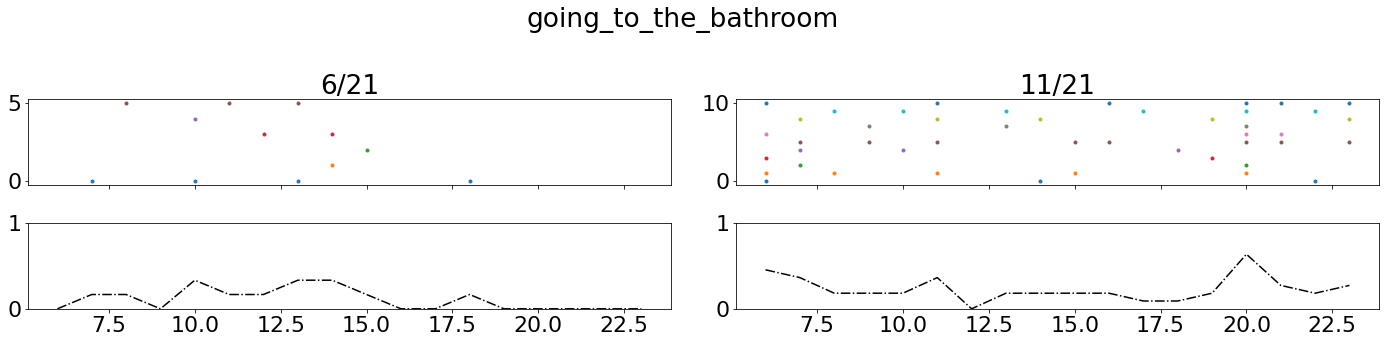

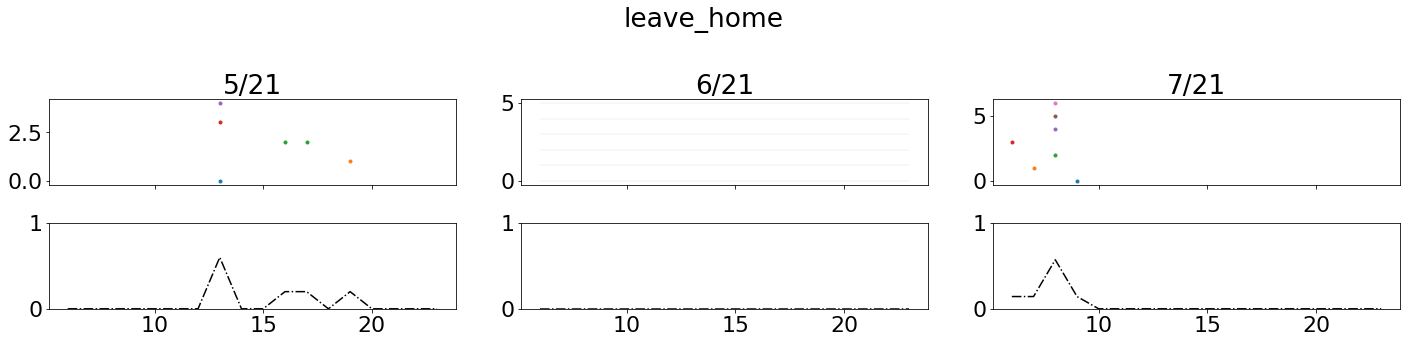

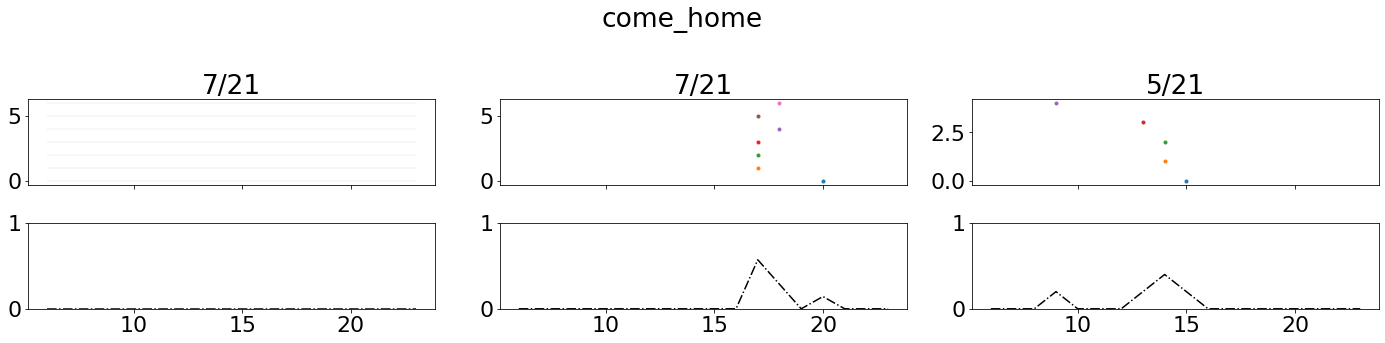

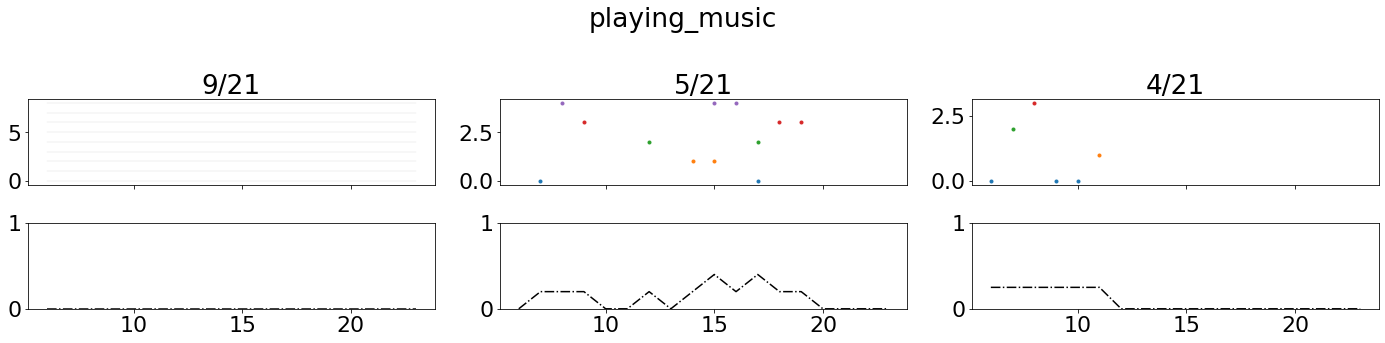

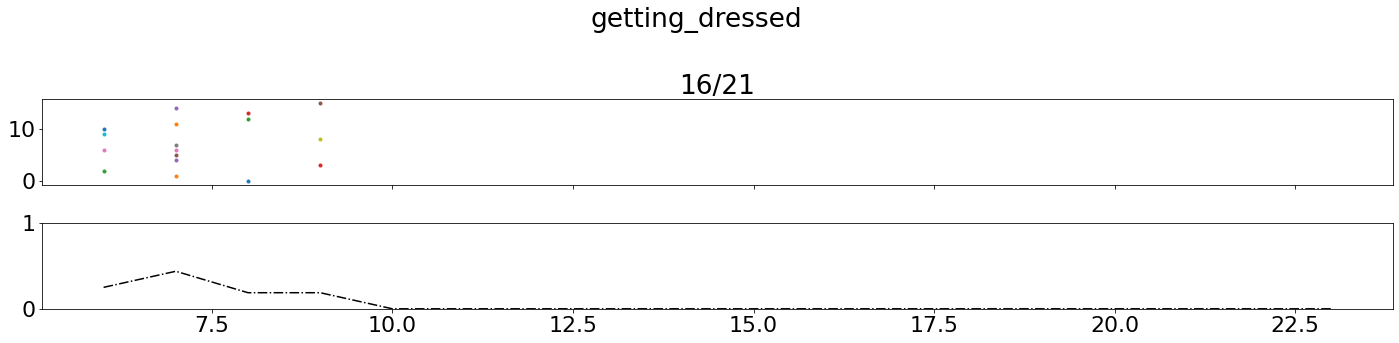

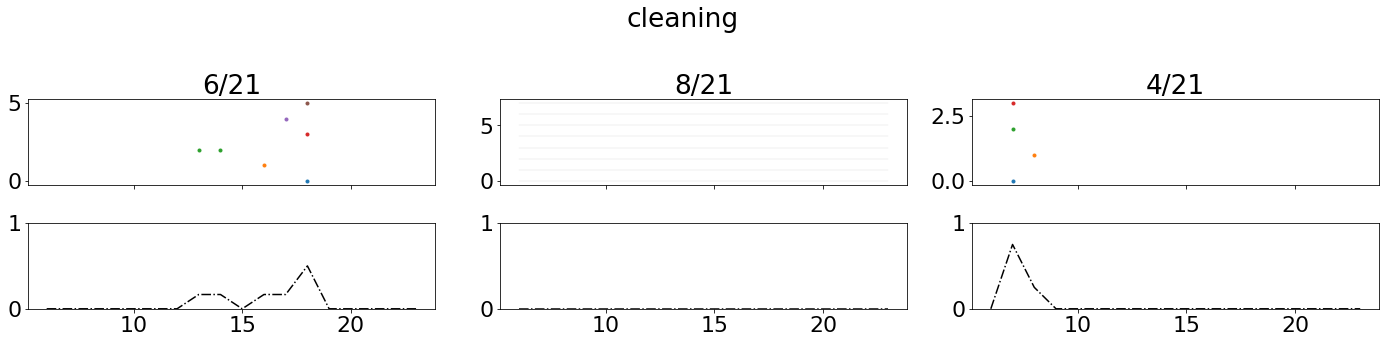

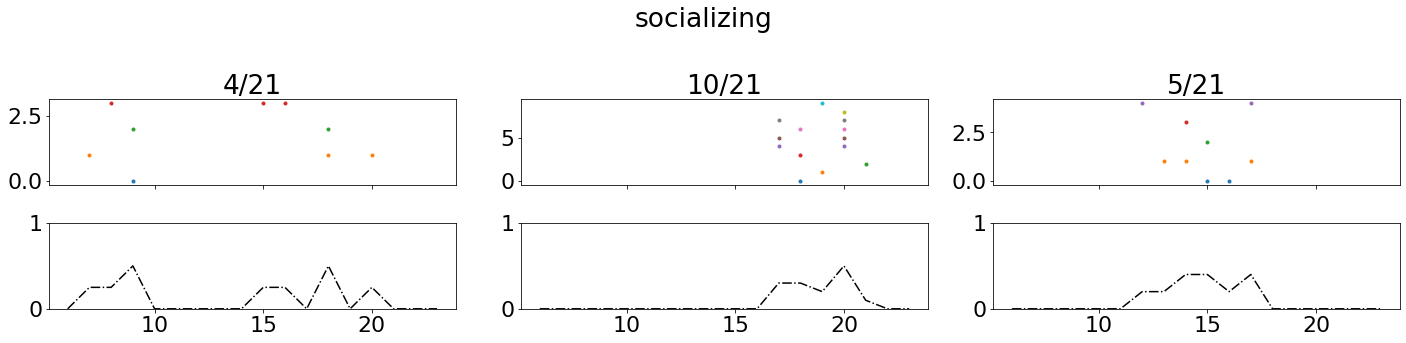

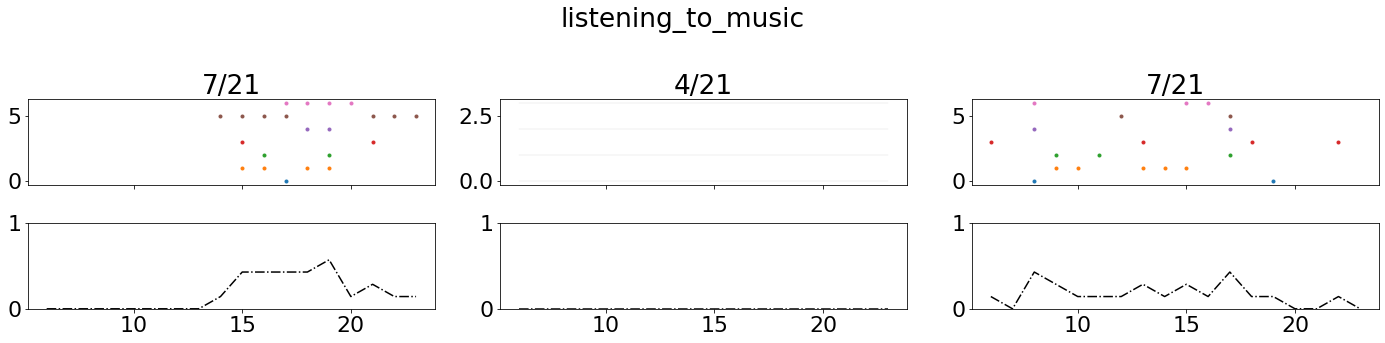

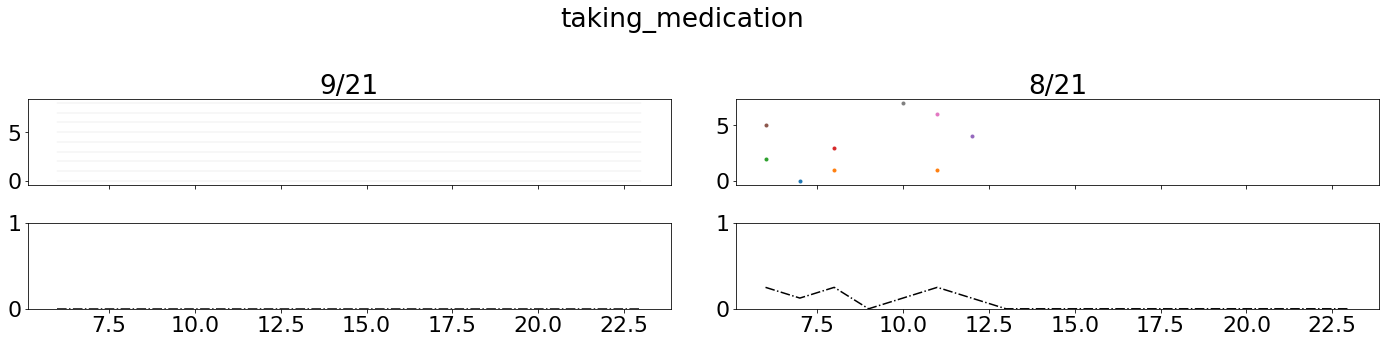

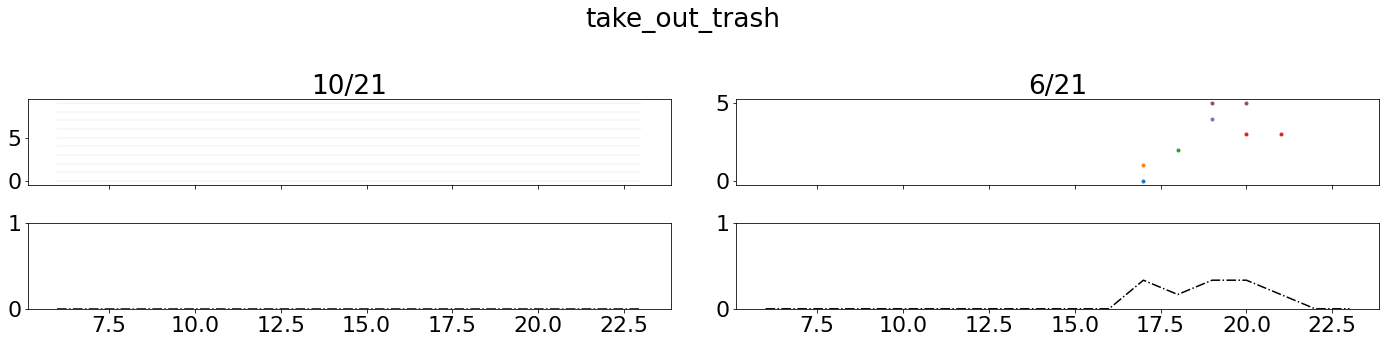

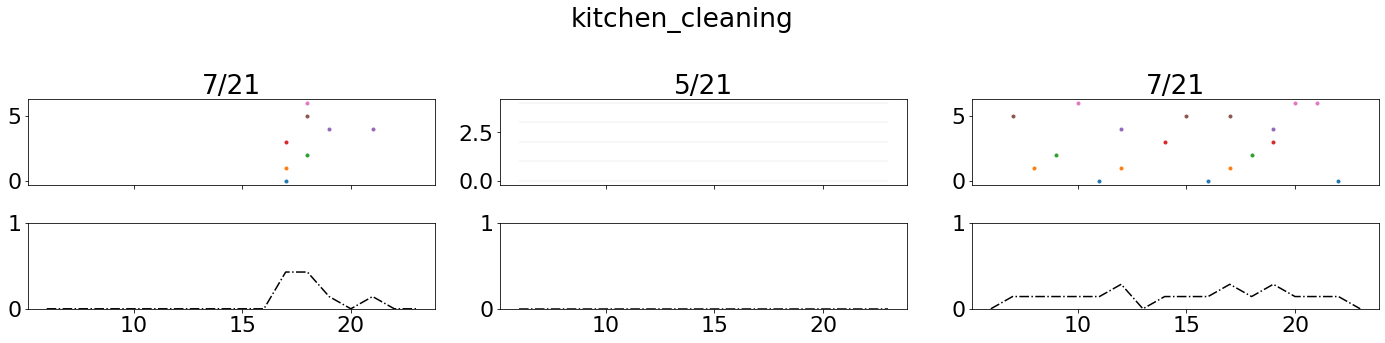

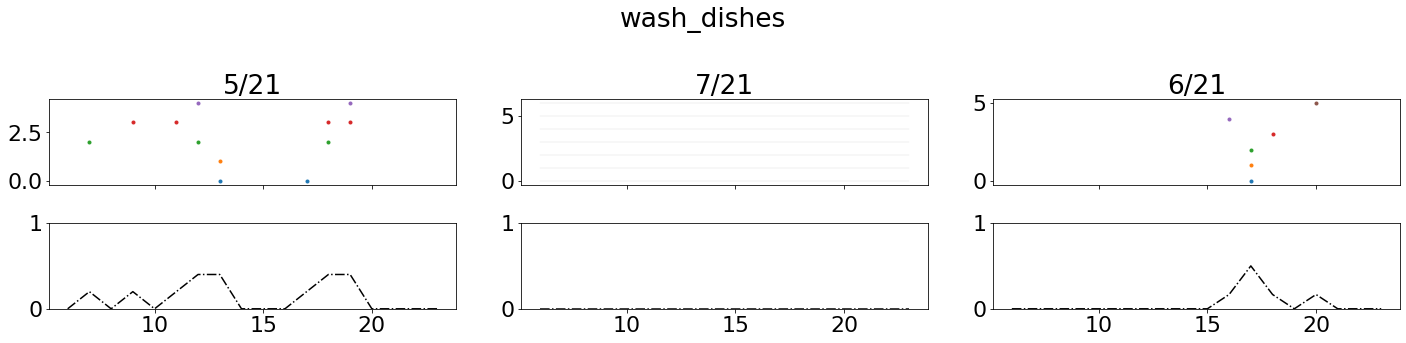

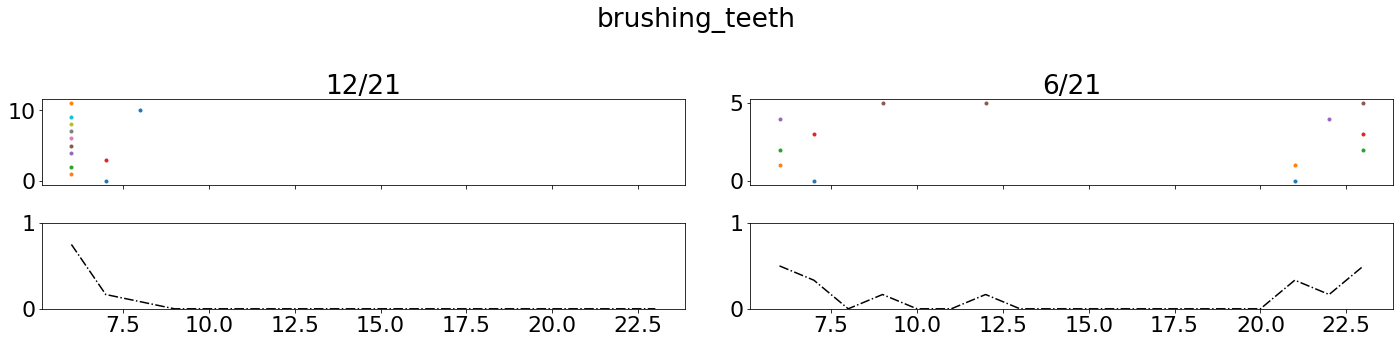

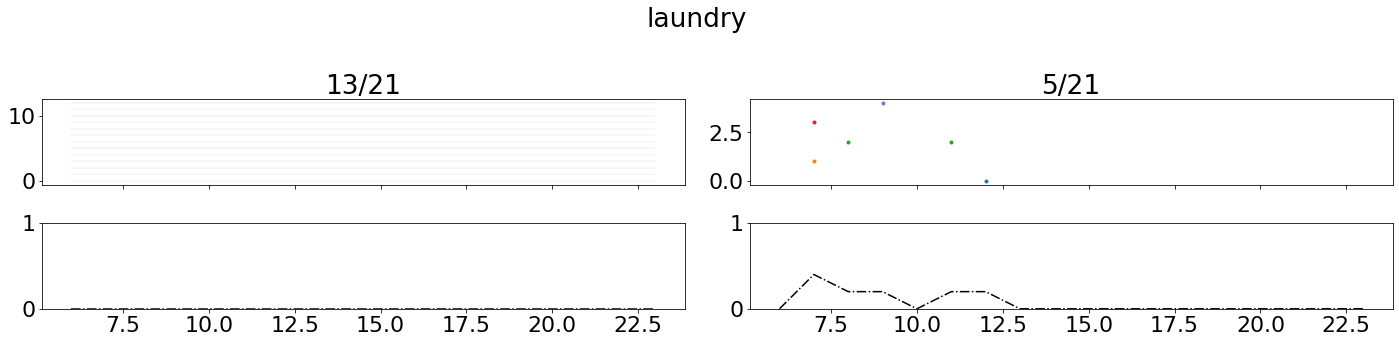

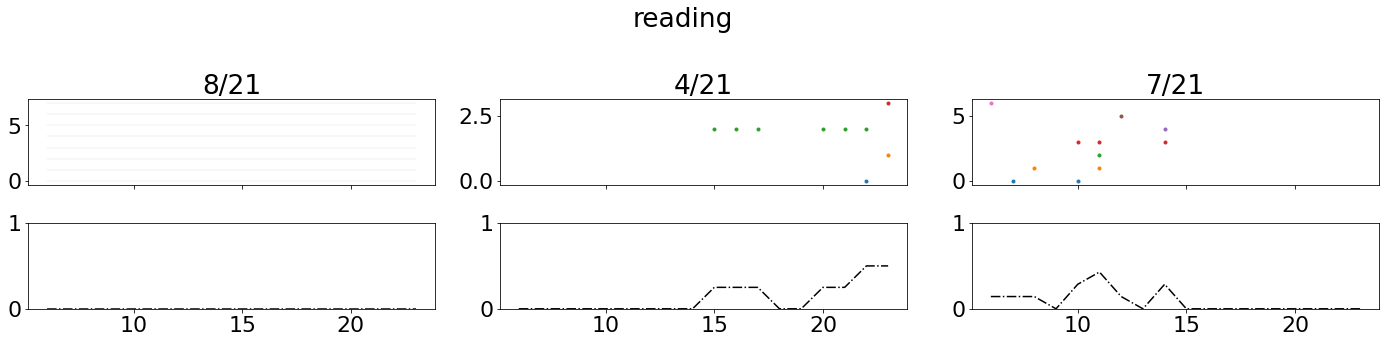

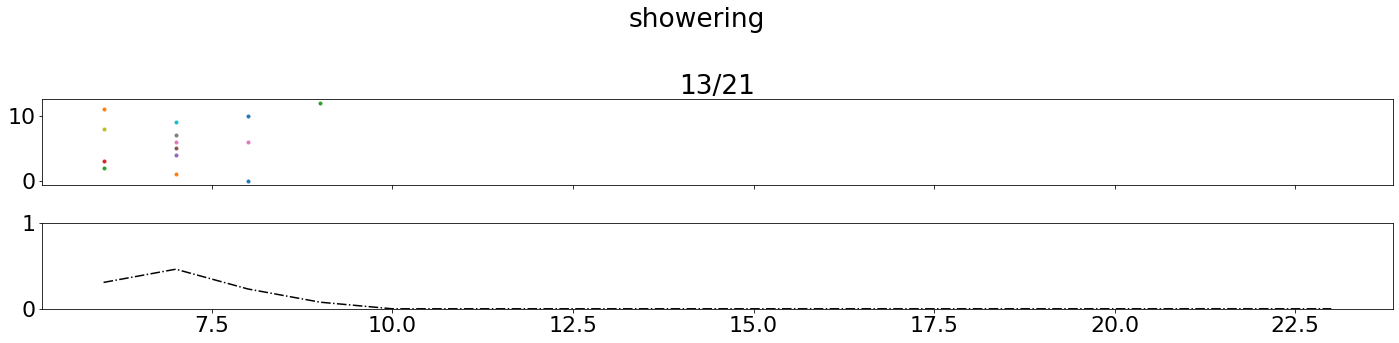

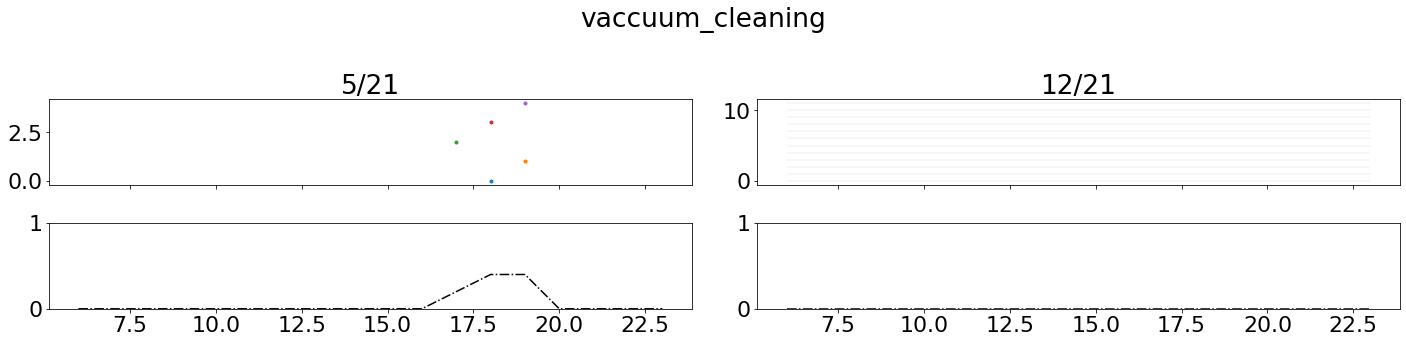

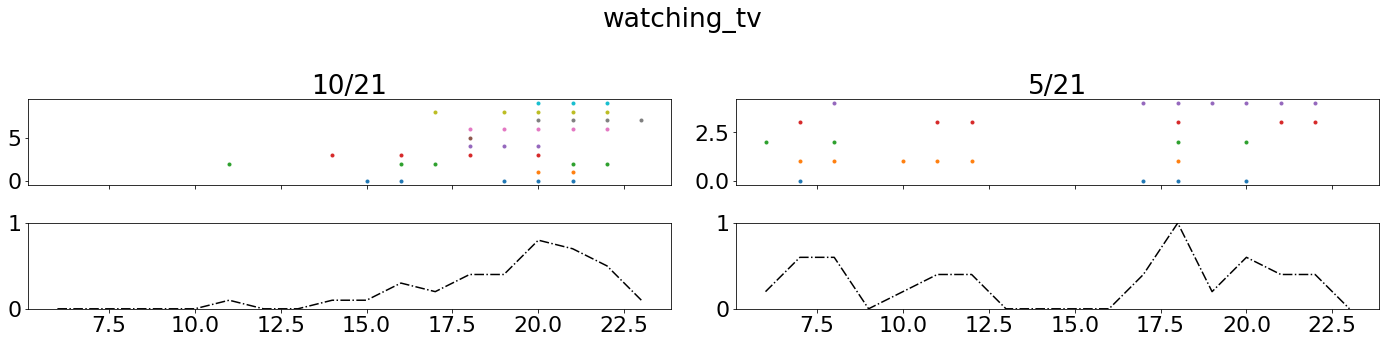

In [100]:
from ScheduleDistributionSampler import ScheduleDistributionSampler
import shutil

typename = 'new'

# goodness = []
# c2c = []
# s2c = []
# ch_score = []
# db_score = []
# sh_score = []

cluster_lengths = [4]
all_clusters = {k:None for k in cluster_lengths}
cluster_histograms = {}

if not os.path.exists('data/personaBasedSchedules/histograms/'):
    os.makedirs('data/personaBasedSchedules/histograms/')

for activity in activities:
    for n_clusters in cluster_lengths:
        individual_names = list(individual_features[activity].keys())
        individual_features_array = np.array(np.array(list(individual_features[activity].values())))
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(individual_features_array)
        clusters = []
        for n in range(n_clusters):
            clusters.append([name for i,name in enumerate(individual_names) if kmeans.labels_[i]==n])
        # cluster_center_distances = []
        # for c1 in kmeans.cluster_centers_:
        #     for c2 in kmeans.cluster_centers_:
        #         cluster_center_distances.append(np.linalg.norm(c1-c2))
        # avg_center_dist = sum(cluster_center_distances)/(n_clusters * (n_clusters-1))
        # sample_to_center_dist = kmeans.transform(individual_features_array).min(axis=-1)

        # goodness.append(avg_center_dist/sample_to_center_dist.mean())
        # c2c.append(avg_center_dist)
        # s2c.append(sample_to_center_dist.mean())
        # ch_score.append(calinski_harabasz_score(individual_features_array, kmeans.labels_))
        # db_score.append(davies_bouldin_score(individual_features_array, kmeans.labels_))
        # sh_score.append(silhouette_score(individual_features_array, kmeans.labels_))

        clusters_used = []
        cluster_histograms[activity] = []
        for i, cluster in enumerate(clusters):
            avg = np.array([individual_histograms[ind][activity] for ind in cluster]).mean(axis=0)
            if len(cluster) > 3:
                cluster_histograms[activity].append(list(avg))
                clusters_used.append(cluster)
                
        fig, axs = plt.subplots(2, len(cluster_histograms[activity]), sharex=True)
        axs = axs.reshape(2,-1)
        fig.set_size_inches(20, 5)
        fig.suptitle(f'{activity}')
        for i,(avg,cluster) in enumerate(zip(cluster_histograms[activity],clusters_used)):
            axs[1][i].plot(start_times, avg, '-.k')
            axs[1][i].set_ylim([0,1])
            plot_together([individual_histograms[ind][activity] for ind in cluster], axs[0][i])
            axs[0][i].set_title(f'{len(cluster)}/21')
        fig.tight_layout()
        plt.savefig('data/personaBasedSchedules/histograms/'+activity+'.jpg')
    

with open('data/personaBasedSchedules/cluster_histograms.json','w') as f:
    json.dump(cluster_histograms, f, indent=4)


In [ ]:
# cluster_histograms_writable = [{k:list(v) for k,v in ch.items()} for ch in cluster_histograms]

In [ ]:
# with open('data/personaBasedSchedules/cluster_histograms.json','w') as f:
#     json.dump(cluster_histograms_writable, f)

### Optimize for distinct persona

- Define a fitness function : Say average KL metric? Intersection over Union metric
- Start with 'n' candidates containing randomly put-together 'p' persona
- To propagate
    - Select best 'k' candidates
    - Generate best 'n' candidate parent groups by choosing 'p*n' OR '2*n' parents
    - Splice parents to form 'n' candidates
    - Add random mutation to form final pool

In [2]:
set_seed = 23424
random.seed(set_seed)

In [3]:
with open('data/personaBasedSchedules/cluster_histograms.json') as f:
    cluster_histograms = json.load(f)
activities = list(cluster_histograms.keys())

In [4]:
P = 5
N = 20
K = 10

In [5]:
def get_histogram(persona):
    return {act:cluster_histograms[act][choice] for act,choice in zip(activities,persona)}
    
def get_random_persona():
    persona = []
    for act in activities:
        activity_options = np.arange(len(cluster_histograms[act]))
        persona.append(random.choice(activity_options))
    return persona

def get_candidate():
    return [get_random_persona() for _ in range(P)]

def get_initial_pool():
    return [get_candidate() for _ in range(N)]

def valid(persona):
    leave_idx = persona[activities.index('leave_home')]
    come_idx = persona[activities.index('come_home')]
    leave_sum = np.sum(cluster_histograms['leave_home'][leave_idx])
    come_sum = np.sum(cluster_histograms['come_home'][come_idx])
    if leave_sum == 0 and come_sum == 0:
        return 1
    if (leave_sum == 0 and come_sum > 0) or (leave_sum > 0 and come_sum == 0):
        return 0
    leave_mean_cumul = np.cumsum(cluster_histograms['leave_home'][leave_idx])
    come_mean_cumul = np.cumsum(cluster_histograms['come_home'][come_idx])
    leave_mean = int(max(np.argwhere(leave_mean_cumul<0.5)))
    come_mean = int(max(np.argwhere(come_mean_cumul<0.5)))
    return float(come_mean > leave_mean)


def fitness(candidate):
    kl_mat = np.zeros((len(candidate), len(candidate)))
    for i1,per1 in enumerate(candidate):
        for i2,per2 in enumerate(candidate):
            kl_mat[i1][i2] = valid(per1) * valid(per2) * KLdivergence(get_histogram(per1), get_histogram(per2))
    return np.mean(kl_mat)

def get_pool_fitness(pool):
    return np.array([fitness(candidate) for candidate in pool])

def get_best_k(pool, k=K):
    pool_fitness = get_pool_fitness(pool)
    best_k_idx = pool_fitness.argsort()[::-1][:k]
    return [pool[idx] for idx in best_k_idx], pool_fitness[best_k_idx]

# def mate(parents, num_children=N):
#     all_personas = []
#     for parent in parents:
#         all_personas += parent
#     assert len(all_personas) > P
#     children = []
#     for _ in range(num_children):
#         random.shuffle(all_personas)
#         children.append(all_personas[0:P])
#     return children

def mate(parents):
    random.shuffle(parents)
    children = [candidate[0:floor(P/2)] for candidate in parents]
    random.shuffle(parents)
    children = [prev+candidate[floor(P/2):] for candidate, prev in zip(parents,children)]
    return children

def mutate(pool):
    for candidate in pool:
        if random.random() < 0.05:
            candidate[random.choice(np.arange(P))] = get_random_persona()
    return pool
    

Iteration 0 : 1.1241980713090065
Iteration 100 : 3.10430984046334
Iteration 200 : 3.115804948250499
Iteration 300 : 3.115804948250499
Iteration 400 : 3.115804948250499
Iteration 500 : 3.1365360825668605
Iteration 600 : 3.1710096671977808
Iteration 700 : 3.1710096671977808
Iteration 800 : 3.1710096671977808
Iteration 900 : 3.1710096671977808
Iteration 0 : 1.2142335859440645
Iteration 100 : 2.882792135458103
Iteration 200 : 2.890439834282552
Iteration 300 : 3.0371334334196023
Iteration 400 : 3.2347511738547103
Iteration 500 : 3.2347511738547103
Iteration 600 : 3.2347511738547103
Iteration 700 : 3.2960807823712885
Iteration 800 : 3.402891051812966
Iteration 900 : 3.402891051812966
Iteration 0 : 1.069067371099184
Iteration 100 : 3.033258963055814
Iteration 200 : 3.172614484330339
Iteration 300 : 3.196401168230106
Iteration 400 : 3.2119842074221494
Iteration 500 : 3.2119842074221494
Iteration 600 : 3.2119842074221494
Iteration 700 : 3.2119842074221494
Iteration 800 : 3.2119842074221494
Iter

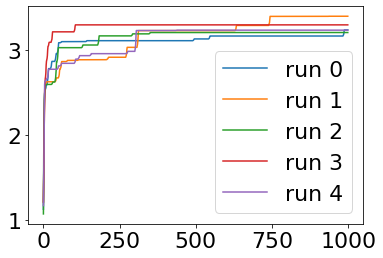

In [6]:
best_finds = []
best_fitnesses = []
for rst in range(5):
    avg_fitness = []
    pool = get_initial_pool()
    for iter in range(1000):
        parents, fitnesses = get_best_k(pool)
        avg_fitness.append(np.mean(fitnesses))
        if iter%100 == 0:
            print(f'Iteration {iter} : {avg_fitness[-1]}')
        children = mate(parents)
        children = mutate(children)
        pool = parents + children

    plt.plot(avg_fitness, label=f'run {rst}')

    best_candidate, best_fittness = get_best_k(pool,1)
    best_candidate = (best_candidate[0])
    result = [[int(idx) for idx in cand] for cand in best_candidate]
    best_finds.append(result)
    best_fitnesses.append(best_fittness)

plt.legend()

In [10]:
best_finds[1]

[[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 2, 1, 1, 0, 0, 0, 0],
 [2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 2, 0, 1, 0],
 [1, 1, 2, 1, 0, 2, 1, 1, 0, 0, 2, 1, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1],
 [1, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 0, 1, 2, 1, 0, 0, 2, 0, 1, 1]]

In [ ]:
result = best_finds[1]

In [36]:
persona = {}
for i,cand in enumerate(result):
    persona['persona'+str(i)] = {a:idx for a,idx in zip(activities, cand)}

with open('data/personaBasedSchedules/optimized_persona.json', 'w') as f:
    json.dump(persona, f, indent=4)